***
# <font color=green size=10>Lista 1: geração de números pseudo-aleatórios</font>
***

▶ Importando bibliotecas

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import string

In [ ]:
SEED = 42

### Questão 1 - Simulando computacionalmente o gerador de Babel


▶ Definindo parâmetros para a questão

In [2]:
# cria um dataset do alfabeto contendo a letra, se é vogal e a frequência da letra na língua portuguesa
alfabeto = pd.DataFrame(list(zip(list(string.ascii_lowercase),
                                 [1 if l in "aeiou" else 0 for l in list(string.ascii_lowercase)],
                                 [0.1463, 0.0104, 0.0388, 0.0499, 0.1257, 0.0102, 0.013, 0.0128,
                                  0.0618, 0.004, 0.0002, 0.0278, 0.0474, 0.0505, 0.1073, 0.0252,
                                  0.012, 0.0653, 0.0781, 0.0434, 0.0463, 0.0166,0.0001, 0.0021,
                                  0.0001, 0.0047])),
                        columns=["letra", "vogal", "frequencia"])
STEP = 10000
num_palavras_possiveis = (alfabeto.shape[0] ** 5)  # amostras ordenadas com reposição - (26^5)

▶ Importando e tratando o dicionário

In [3]:
dicionario = pd.read_csv("Dicionario.txt", names=["vocabulo"])
dicionario.vocabulo = dicionario.vocabulo.str.strip()
dicionario.vocabulo = dicionario.vocabulo.str.lower()
dicionario.drop_duplicates(inplace=True, ignore_index=True)
dicionario["tamanho"] = dicionario.vocabulo.str.len()

▶ Definindo funções auxiliares

In [4]:
def gerar_amostra_seq_caracteres_aleatoria(n=10**6, tamanho_seq_carateres=5, vogais_consoantes_alternadas=False, p_uniforme=True, random_state=None):
    if random_state != None:
        np.random.seed(random_state)

    letras = alfabeto.letra.to_list()

    amostra = []
    for _ in range(n):
        if not vogais_consoantes_alternadas:
            # gera sequência de carateres com 5 letras aleatoriamente

            p = None
            if not p_uniforme:
                # o parâmetro indica se deve ou não ser usada probabilidade de distribuição uniforme
                # caso não seja uniforme, distribui ajusta a probabilidade de acordo com a frequência do aparecimento
                # de cada uma das letras do alfabeto na língua portuguesa
                p = alfabeto.frequencia.to_list()

            while True:
                sequencia_caracteres = ''.join(np.random.choice(letras, size=tamanho_seq_carateres, replace=True, p=p))
                if (not p_uniforme and "a" in sequencia_caracteres) or p_uniforme:
                    break

        else:
            # gera sequência de caracteres, alternando-se vogais e consoantes aleatórias

            # inicia variáveis
            vogais = alfabeto.query("vogal == 1").letra.to_list()
            consoantes = alfabeto.query("vogal == 0").letra.to_list()
            letra_corrente_vogal = False

            # gera a primeira letra da sequência de caracteres e registra se é uma vogal
            sequencia_caracteres = np.random.choice(letras)
            if sequencia_caracteres in vogais:
                letra_corrente_vogal = True

            # gera as demais letras da sequência até atingir o tamanho estabelecido no parâmetro
            for _ in range(1, tamanho_seq_carateres):
                if letra_corrente_vogal:
                    sequencia_caracteres += np.random.choice(consoantes)
                else:
                    sequencia_caracteres += np.random.choice(vogais)
                letra_corrente_vogal = not letra_corrente_vogal

        amostra.append(sequencia_caracteres)

    return amostra

In [5]:
def executar_simulacao_monte_carlo(amostra, dicionario_lista=None):
    palavras_validas_geradas = []
    num_instancias_simulacao = STEP
    probabilidades = pd.DataFrame()

    for idx, sequencia_caracteres in enumerate(amostra):
        if dicionario_lista != None:
            if sequencia_caracteres in dicionario_lista:
                palavras_validas_geradas.append(sequencia_caracteres)
        else:
            if sequencia_caracteres == sequencia_caracteres[::-1]:
                palavras_validas_geradas.append(sequencia_caracteres)


        if idx + 1 == num_instancias_simulacao:
            num_palavras_validas_geradas = len(palavras_validas_geradas)
            probabilidade_simulacao = num_palavras_validas_geradas / num_instancias_simulacao
            probabilidades = pd.concat([probabilidades,
                                        pd.DataFrame({"num_instancias": [num_instancias_simulacao],
                                                      "num_palavras_validas_geradas": [num_palavras_validas_geradas],
                                                      "probabilidade": [probabilidade_simulacao],
                                                      "palavras_validas_geradas": [str(palavras_validas_geradas)]})],
                                       axis=0, ignore_index=True)
            num_instancias_simulacao += STEP

    return probabilidades

In [6]:
def plotar_grafico(probabilidades_estimadas):
    ax = sns.lineplot(data=probabilidades_estimadas, x="num_instancias", y="probabilidade")
    ax.figure.set_size_inches(14, 6)
    ax.hlines(y=probabilidades_estimadas.probabilidade.mean(), xmin=0, xmax=probabilidades_estimadas.num_instancias.max(), colors='red', linestyles='dashed')

**a)** Estime via simulação computacional (Monte Carlo) a probabilidade de se gerar uma palavra válida
 (isso é, do dicionário) ao sortear ao acaso sequências de 5 letras (todas com a mesma probabilidade). Em
seguida, calcule analiticamente tal probabilidade e faça um gráfico indicando se a estimativa obtida se
aproxima do valor teórico conforme a amostra aumenta. **Atenção**: utilize somente as letras do alfabeto
sem carateres especiais.


▶ Derivando o dicionário apenas com palavras de 5 letras

In [7]:
dicionario_5_letras = dicionario.query("tamanho == 5")
dicionario_5_letras.head()

,vocabulo,tamanho
1,aarao,5
11,abaco,5
13,abade,5
19,abafa,5
69,abafe,5


▶ Obtendo as probabilidades e plotando o gráfico

In [8]:
amostra_5_letras = []

In [32]:
try:
    probabilidades_estimadas_5_letras = pd.read_csv("probabilidades_estimadas_5_letras.csv")
except FileNotFoundError:
    amostra_5_letras = gerar_amostra_seq_caracteres_aleatoria(random_state=SEED)
    probabilidades_estimadas_5_letras = executar_simulacao_monte_carlo(amostra_5_letras, dicionario_5_letras.vocabulo.to_list())
    probabilidades_estimadas_5_letras.to_csv("probabilidades_estimadas_5_letras.csv", index=False)

In [33]:
print(f"Probabilidade média estimada das simulações: {probabilidades_estimadas_5_letras.probabilidade.mean() * 100:0.8f}%")

num_palavras_dicionario_5_letras = dicionario_5_letras.shape[0]
probabilidade_teorica_5_letras = num_palavras_dicionario_5_letras / num_palavras_possiveis
print(f"Probabilidade teórica de uma palavra válida de 5 letras: {probabilidade_teorica_5_letras * 100:0.8f}%")

Probabilidade média estimada das simulações: 0.04665845%
Probabilidade teórica de uma palavra válida de 5 letras: 0.04567653%


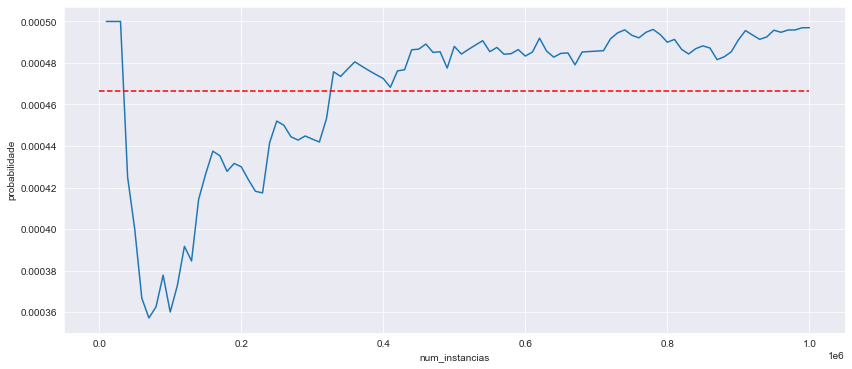

In [34]:
plotar_grafico(probabilidades_estimadas_5_letras)

**b)** Estime a probabilidade da sequência gerada ser um palíndromo (ou seja, pode ser lida, indiferentemente,
da esquerda para direita ou da direita para esquerda). Compare o resultado com a probabilidade exata,
calculada analiticamente.

In [36]:
try:
    probabilidades_estimadas_palindromo = pd.read_csv("probabilidades_estimadas_palindromo.csv")
except FileNotFoundError:
    probabilidades_estimadas_palindromo = executar_simulacao_monte_carlo(amostra_5_letras)
    probabilidades_estimadas_palindromo.to_csv("probabilidades_estimadas_palindromo.csv", index=False)

In [37]:
print(f"Probabilidade média estimada das simulações: {probabilidades_estimadas_palindromo.probabilidade.mean() * 100:0.8f}%")

probabilidade_teorica_palindromo = 26 ** 3 / num_palavras_possiveis
print(f"Probabilidade teórica de um palíndromo de 5 letras: {probabilidade_teorica_palindromo * 100:0.8f}%")

Probabilidade média estimada das simulações: 0.15311073%
Probabilidade teórica de um palíndromo de 5 letras: 0.14792899%


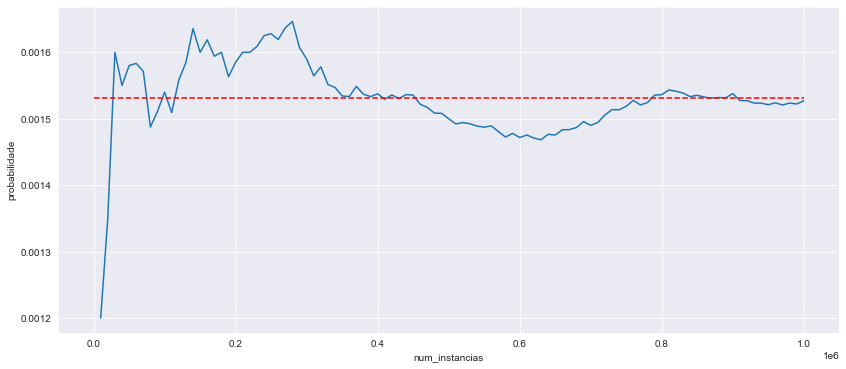

In [38]:
plotar_grafico(probabilidades_estimadas_palindromo)

<b>c)</b> Construa um gerador que alterne entre consoantes e vogais (se uma letra for uma vogal, a próxima será
uma consoante e vice-versa). Qual a probabilidade de gerar uma palavra válida com este novo gerador?

In [41]:
try:
    probabilidades_estimadas_vogais_consoantes_alternadas = pd.read_csv("probabilidades_estimadas_vogais_consoantes_alternadas.csv")
except FileNotFoundError:
    amostra_vogais_consoantes_alternadas = gerar_amostra_seq_caracteres_aleatoria(vogais_consoantes_alternadas=True, random_state=SEED)
    probabilidades_estimadas_vogais_consoantes_alternadas = executar_simulacao_monte_carlo(amostra_vogais_consoantes_alternadas,
                                                                                           dicionario_5_letras.vocabulo.to_list())
    probabilidades_estimadas_vogais_consoantes_alternadas.to_csv("probabilidades_estimadas_vogais_consoantes_alternadas.csv", index=False)

In [16]:
print(f"Probabilidade média estimada das simulações: {probabilidades_estimadas_vogais_consoantes_alternadas.probabilidade.mean() * 100:0.8f}%")

Probabilidade média estimada das simulações: 0.70351765%


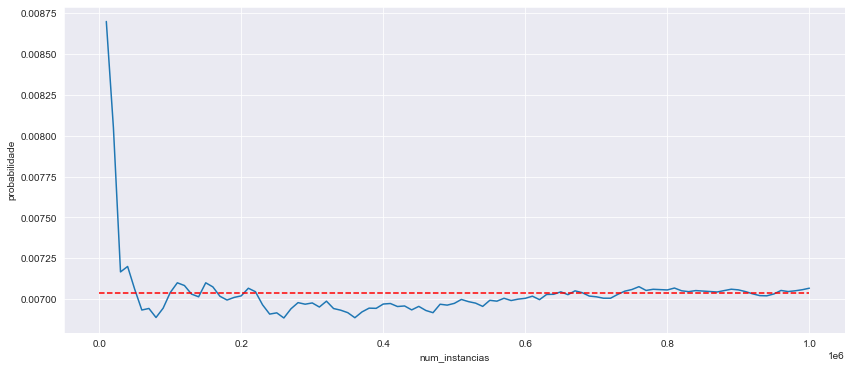

In [17]:
plotar_grafico(probabilidades_estimadas_vogais_consoantes_alternadas)

**d)** Considere um processo gerador de sequências de 5 caracteres no qual cada letra é sorteada com
probabilidade proporcional à sua respectiva frequência na língua portuguesa (veja essa [página](https://pt.wikipedia.org/wiki/Frequ%C3%AAncia_de_letras)). Suponha
que esse processo gerou uma sequência com ao menos um “a”. Neste caso, estime a probabilidade dessa
sequência ser uma palavra válida.

In [42]:
try:
    probabilidades_estimadas_frequencia_5_letras = pd.read_csv("probabilidades_estimadas_frequencia_5_letras.csv")
except FileNotFoundError:
    amostra_frequencia_5_letras = gerar_amostra_seq_caracteres_aleatoria(p_uniforme=False, random_state=SEED)
    probabilidades_estimadas_frequencia_5_letras = executar_simulacao_monte_carlo(amostra_frequencia_5_letras,
                                                                                  dicionario_5_letras.vocabulo.to_list())
    probabilidades_estimadas_frequencia_5_letras.to_csv("probabilidades_estimadas_frequencia_5_letras.csv", index=False)

In [19]:
print(f"Probabilidade média estimada das simulações: {probabilidades_estimadas_frequencia_5_letras.probabilidade.mean() * 100:0.8f}%")

Probabilidade média estimada das simulações: 1.01409731%


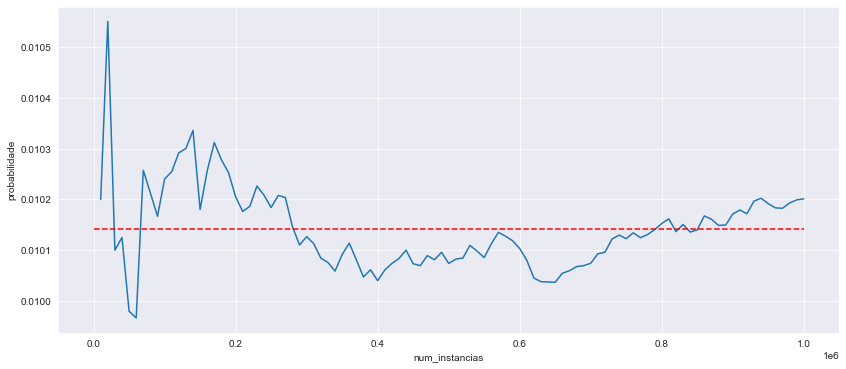

In [20]:
plotar_grafico(probabilidades_estimadas_frequencia_5_letras)

Questão 2

**a)**

In [21]:
def gerar_amostra_aleatoria_cauchy(n, gama=1, random_state=None):
    if random_state != None:
        np.random.seed(random_state)

    probabilidades = np.random.uniform(size=n)
    amostra = []
    for p in probabilidades:
        amostra.append(gama * np.tan(np.pi * (p - 0.5)))

    if len(amostra) == 1:
        return amostra[0]

    return amostra

In [22]:
amostra_cauchy = gerar_amostra_aleatoria_cauchy(100, random_state=SEED)
amostra_cauchy[:5]

[-0.41590721785011475,
 6.406769634650998,
 0.8928135381621737,
 0.3202666081032517,
 -1.8741437429251895]

<AxesSubplot:ylabel='Density'>

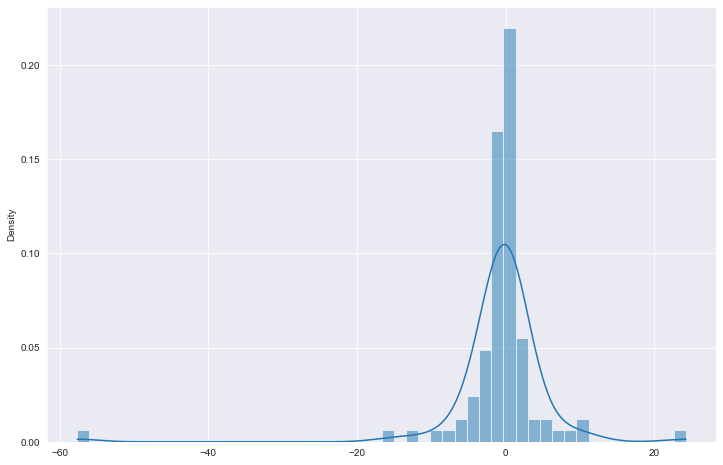

In [23]:
ax = sns.histplot(amostra_cauchy, kde=True, bins=50, stat="density")
ax.figure.set_size_inches(12, 8)
ax

**b)**

In [24]:
dados = pd.DataFrame([[2, 0.2], [3, 0.1], [5, 0.2], [7, 0.2], [9, 0.3]], columns=["numero", "probabilidade"])
dados["probabilidade_acumulada"] = dados.probabilidade.cumsum()
dados

,numero,probabilidade,probabilidade_acumulada
0,2,0.2,0.2
1,3,0.1,0.3
2,5,0.2,0.5
3,7,0.2,0.7
4,9,0.3,1.0


In [25]:
def gerar_amostra_aleatoria_x(n=1000, random_state=None):
    if random_state != None:
        np.random.seed(random_state)

    probabilidades = np.random.uniform(size=n)
    amostra = []
    for p in probabilidades:
        amostra.append(dados.query(f"probabilidade_acumulada >= {p}").numero.min())

    if len(amostra) == 1:
        return amostra[0]

    return amostra

In [26]:
amostra_gerador_x = gerar_amostra_aleatoria_x(random_state=SEED)
probabilidades_amostra_gerador = pd.Series(amostra_gerador_x, name="probabilidade_amostra_gerador").value_counts(normalize=True).sort_index()

tabela_freq_relativa = dados.filter(["numero", "probabilidade"])
tabela_freq_relativa = tabela_freq_relativa.join(probabilidades_amostra_gerador, on="numero")
tabela_freq_relativa

,numero,probabilidade,probabilidade_amostra_gerador
0,2,0.2,0.225
1,3,0.1,0.094
2,5,0.2,0.184
3,7,0.2,0.209
4,9,0.3,0.288


In [27]:
np.random.seed(SEED)
amostra_numpy = np.random.choice(dados.numero, size=1000, replace=True, p=dados.probabilidade)
probabilidades_amostra_numpy = pd.Series(amostra_numpy, name="probabilidade_amostra_numpy").value_counts(normalize=True).sort_index()

tabela_freq_relativa = tabela_freq_relativa.join(probabilidades_amostra_numpy, on="numero")
tabela_freq_relativa

,numero,probabilidade,probabilidade_amostra_gerador,probabilidade_amostra_numpy
0,2,0.2,0.225,0.225
1,3,0.1,0.094,0.094
2,5,0.2,0.184,0.184
3,7,0.2,0.209,0.209
4,9,0.3,0.288,0.288


**c)** Escreva uma função que gere amostras da distribuição Normal padrão (μ = 0, σ = 1) usando o método
de aceitação e rejeição adotando como função geradora de candidatos, g(x), a distribuição Cauchy padrão
(isso é, com γ = 1).

In [28]:
def normal_pdf(x, mu=0, sigma=1):
    return (1 / (sigma * np.sqrt(2 * np.pi))) * np.e ** (-0.5 * ((x - mu) / sigma) ** 2)

def cauchy_pdf(x, gama=1):
    return 1 / (np.pi * gama * (1 + (x / gama) ** 2))

In [65]:
def gerar_amostra_aleatoria_normal(n=1000, random_state=None):
    if random_state != None:
        np.random.seed(random_state)

    c = normal_pdf(1) / cauchy_pdf(1)

    probabilidades = np.random.uniform(size=n)
    amostra_cauchy = gerar_amostra_aleatoria_cauchy(n, random_state=random_state)
    amostra = []

    for idx, p in enumerate(probabilidades):
        y = amostra_cauchy[idx]
        u = np.random.uniform()

        if u < (normal_pdf(y) / (c * cauchy_pdf(y))):
            amostra.append(y)

    return amostra

In [66]:
amostra_normal = gerar_amostra_aleatoria_normal(10000, random_state=SEED)
amostra_normal[:5]

[-0.41590721785011475,
 0.8928135381621737,
 0.3202666081032517,
 -1.8741437429251895,
 0.3287968499676262]

<AxesSubplot:ylabel='Density'>

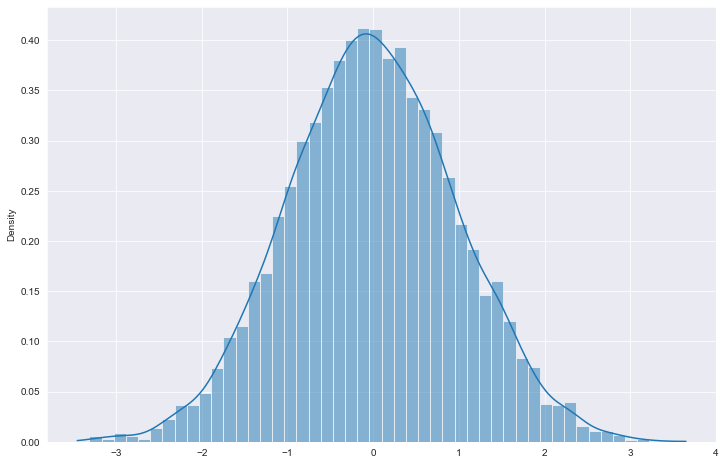

In [67]:
ax = sns.histplot(amostra_normal, kde=True, bins=50, stat="density")
ax.figure.set_size_inches(12, 8)
ax